In [27]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download NLTK data files
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load the dataset
df = pd.read_csv('IMDB Dataset.csv', encoding='latin1')

# Remove unnecessary columns and drop rows with missing text
df = df[['review', 'sentiment']].dropna(subset=['review'])

# Define preprocessing function
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Apply preprocessing
df['cleaned_text'] = df['review'].apply(preprocess_text)

# Map sentiment labels to integers
label_map = {'negative': 0, 'positive': 1}
df['label'] = df['sentiment'].map(label_map)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
import torch
from transformers import AlbertTokenizer, AlbertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split

# Load the ALBERT tokenizer
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

# Tokenize the text with a reduced maximum length
def tokenize_function(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=128)

# Split the data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(df['cleaned_text'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42)

# Tokenize the datasets
train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)

# Create PyTorch datasets
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

C:\Users\asus\anaconda3\lib\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\asus\.cache\huggingface\hub\models--albert-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

In [18]:
from sklearn.model_selection import StratifiedKFold
# Define metrics function
def compute_metrics(p):
    accuracy_metric = evaluate.load("accuracy")
    precision_metric = evaluate.load("precision")
    recall_metric = evaluate.load("recall")
    f1_metric = evaluate.load("f1")

    logits, labels = p
    logits = torch.tensor(logits)
    labels = torch.tensor(labels)

    predictions = torch.argmax(logits, dim=-1)

    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels, average='binary')
    recall = recall_metric.compute(predictions=predictions, references=labels, average='binary')
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='binary')

    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"],
    }

# Define the function for cross-validation
def cross_validate_model(df, k=5):
    skf = StratifiedKFold(n_splits=k)
    results = []

    for train_index, val_index in skf.split(df['cleaned_text'], df['label']):
        train_texts, val_texts = df['cleaned_text'].iloc[train_index].tolist(), df['cleaned_text'].iloc[val_index].tolist()
        train_labels, val_labels = df['label'].iloc[train_index].tolist(), df['label'].iloc[val_index].tolist()

        train_encodings = tokenizer(train_texts, padding=True, truncation=True, max_length=128, return_tensors='pt')
        val_encodings = tokenizer(val_texts, padding=True, truncation=True, max_length=128, return_tensors='pt')

        train_dataset = SentimentDataset(train_encodings, train_labels)
        val_dataset = SentimentDataset(val_encodings, val_labels)

        training_args = TrainingArguments(
            output_dir='./results',
            num_train_epochs=2,
            per_device_train_batch_size=8,
            per_device_eval_batch_size=8,
            warmup_steps=500,
            weight_decay=0.01,
            logging_dir='./logs',
            logging_steps=3,
            evaluation_strategy="epoch",
            fp16=torch.cuda.is_available()  # Use mixed precision training if available
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics
        )

        trainer.train()
        eval_result = trainer.evaluate()
        results.append(eval_result)
    
    avg_results = {metric: sum([result[metric] for result in results]) / k for metric in results[0]}
    return avg_results

# Perform cross-validation
cv_results = cross_validate_model(df, k=5)

print(f"Cross-Validation Results:")
print(f"Validation Loss: {cv_results['eval_loss']}")
print(f"Validation Accuracy: {cv_results['eval_accuracy']}")
print(f"Validation Precision: {cv_results['eval_precision']}")
print(f"Validation Recall: {cv_results['eval_recall']}")
print(f"Validation F1 Score: {cv_results['eval_f1']}")

C:\Users\asus\AppData\Local\Temp\ipykernel_1128\7937413.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.453000,0.618355,0.687898,0.620553,0.987421,0.762136
2,0.779100,0.542718,0.792994,0.821918,0.754717,0.786885


C:\Users\asus\AppData\Local\Temp\ipykernel_1128\7937413.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\asus\AppData\Local\Temp\ipykernel_1128\7937413.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


C:\Users\asus\AppData\Local\Temp\ipykernel_1128\7937413.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.342800,0.408009,0.827476,0.780749,0.918239,0.843931
2,0.566000,0.441493,0.827476,0.777778,0.924528,0.844828


C:\Users\asus\AppData\Local\Temp\ipykernel_1128\7937413.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\asus\AppData\Local\Temp\ipykernel_1128\7937413.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


C:\Users\asus\AppData\Local\Temp\ipykernel_1128\7937413.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.279000,0.548265,0.865815,0.960630,0.767296,0.853147
2,0.520700,0.411895,0.878594,0.866667,0.899371,0.882716


C:\Users\asus\AppData\Local\Temp\ipykernel_1128\7937413.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\asus\AppData\Local\Temp\ipykernel_1128\7937413.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


C:\Users\asus\AppData\Local\Temp\ipykernel_1128\7937413.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.009400,0.381911,0.923323,0.972028,0.874214,0.920530
2,0.232700,0.360572,0.920128,0.946667,0.893082,0.919094


C:\Users\asus\AppData\Local\Temp\ipykernel_1128\7937413.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\asus\AppData\Local\Temp\ipykernel_1128\7937413.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


C:\Users\asus\AppData\Local\Temp\ipykernel_1128\7937413.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.200100,0.130741,0.971246,0.962963,0.981132,0.971963
2,0.579900,0.141793,0.968051,0.980645,0.955975,0.968153


C:\Users\asus\AppData\Local\Temp\ipykernel_1128\7937413.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\asus\AppData\Local\Temp\ipykernel_1128\7937413.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Cross-Validation Results:
Validation Loss: 0.3796941518783569
Validation Accuracy: 0.8774485663702407
Validation Precision: 0.8787348161241224
Validation Recall: 0.8855345911949686
Validation F1 Score: 0.8803351197731952


In [37]:
# Ensure the model is in evaluation mode
model.eval()

def analyze_sentiment(sentences):
    tf_batch = tokenizer(sentences, max_length=128, padding=True, truncation=True, return_tensors='pt').to(device)
    with torch.no_grad():
        tf_outputs = model(**tf_batch)
    tf_predictions = torch.nn.functional.softmax(tf_outputs.logits, dim=-1)
    labels = ['Negative', 'Positive']
    label = torch.argmax(tf_predictions, axis=1).cpu().numpy()
    return [labels[l] for l in label]

# Define sentences for sentiment analysis
pred_sentences = ['amr is watch good movie']

# Analyze sentiment
results = analyze_sentiment(pred_sentences)
for sentence, sentiment in zip(pred_sentences, results):
    print(f"{sentence}: {sentiment}")

import matplotlib.pyplot as plt

# Count the number of positive and negative sentiments in the dataset
sentiment_counts = df['sentiment'].value_counts()

amr is watch good movie: Positive


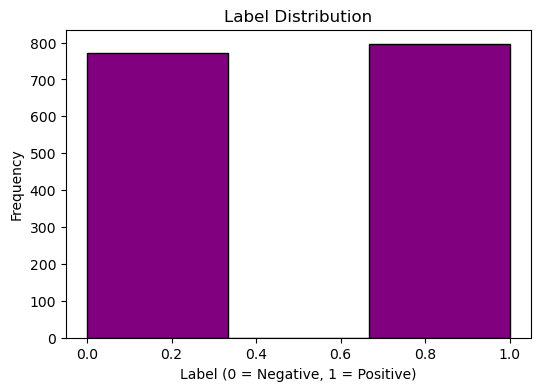

In [40]:
# Additional histograms
df['review_length'] = df['review'].apply(lambda x: len(x.split()))

# Histogram for label distribution
plt.figure(figsize=(6, 4))
plt.hist(df['label'], bins=3, color='purple', edgecolor='black')
plt.title('Label Distribution')
plt.xlabel('Label (0 = Negative, 1 = Positive)')
plt.ylabel('Frequency')
plt.show()

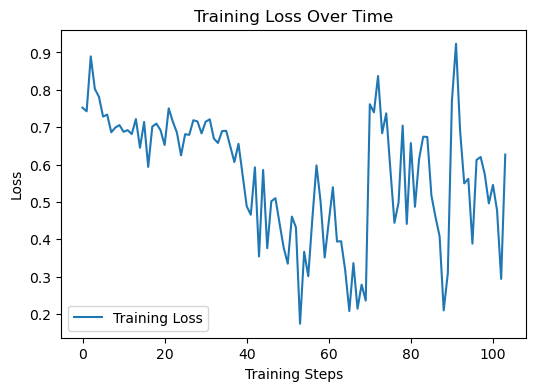

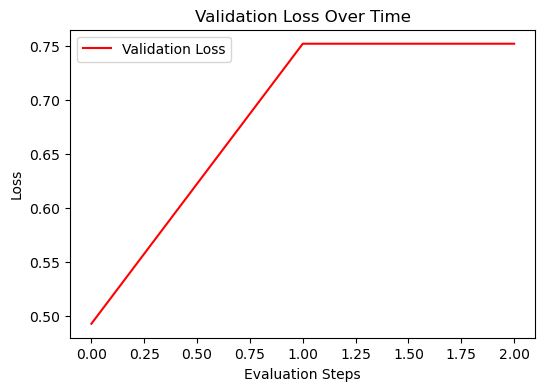

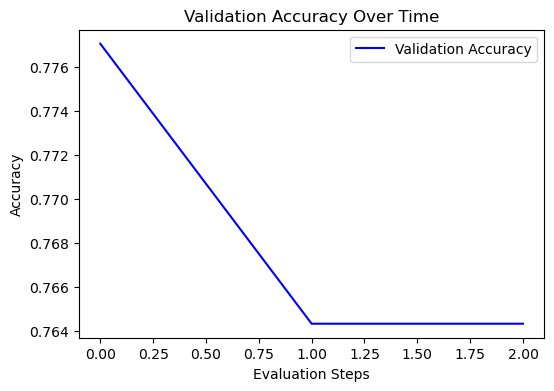

In [33]:
# Additional plots for training and evaluation metrics
# Assuming you have a way to log the metrics during training, typically Trainer in HuggingFace does this
# Extracting the training logs from Trainer object (trainer.state.log_history)

training_logs = trainer.state.log_history

# Extracting specific metrics
train_loss = [log["loss"] for log in training_logs if "loss" in log]
eval_loss = [log["eval_loss"] for log in training_logs if "eval_loss" in log]
eval_accuracy = [log["eval_accuracy"] for log in training_logs if "eval_accuracy" in log]

# Plot training loss
plt.figure(figsize=(6, 4))
plt.plot(train_loss, label='Training Loss')
plt.title('Training Loss Over Time')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot validation loss
plt.figure(figsize=(6, 4))
plt.plot(eval_loss, label='Validation Loss', color='red')
plt.title('Validation Loss Over Time')
plt.xlabel('Evaluation Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot validation accuracy
plt.figure(figsize=(6, 4))
plt.plot(eval_accuracy, label='Validation Accuracy', color='blue')
plt.title('Validation Accuracy Over Time')
plt.xlabel('Evaluation Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()